# Week 9 Day 3

## Objectives
* Discuss calculation performance
* Look at ways to speed up code

> Reminder: You should all have started your projects. You should be able to give a simple report over what you are doing and planning to do two weeks from today.

## Example Numpy calculation

For the following, we will often use normal Numpy as a baseline. Remember it's already a factor of 10 to 100 faster than pure Python!

Let's pretend that we have the following calculation, and it's important to us for some reason:

$$
y = x + x^2 + x^3 + x^4 + x^5 + x^6 + x^7 + x^8
$$

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import numexpr
import numba

For all the following examples, we'll use the same 1M element vector:

In [2]:
x = np.random.normal(size=1_000_000)

#### Simple Python

In [3]:
def f_simple(xarr):
    yarr = np.empty_like(xarr)
    for i in range(len(xarr)):
        x = xarr[i]
        yarr[i] = x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8
    return yarr

In [4]:
%%timeit
f_simple(x)

3.59 s ± 153 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Simple Numpy

In [5]:
def f_numpy(x):
    return x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8

In [6]:
%%timeit
f_numpy(x)

480 ms ± 16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note that this is clean and clear. If this is fast enough for your use case, *stop here*! This is the easiest one to maintain, and is the most similar to the original problem statement.

It is slow, however, We have to make a lot of memory allocations; even though we can reclaim it later, this is slow. Also, raising to a power is a bit pricey too.

#### Algorithmic rearrangement

Let's try to build a new version of the expression that is friendlier to doing in-place calculations. Before we move to in-place calculations, though, let's test the new expression, both against the old one and with a timer:

In [7]:
def f_nest_numpy(x):
    return x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x)))))))

In [8]:
np.testing.assert_allclose(f_numpy(x), f_nest_numpy(x))

In [9]:
%%timeit
f_nest_numpy(x)

7.73 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Numpy reduced memory

Now, let's get rid of all the extra memory allocations. We will allocate once, then just keep changing the memory we've already allocated:

In [10]:
def f_mem_numpy(x):
    y = x.copy()
    for _ in range(7):
        y += 1
        y *= x
    return y

In [11]:
np.testing.assert_allclose(f_numpy(x), f_mem_numpy(x))

In [12]:
%%timeit
f_mem_numpy(x)

7.91 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Wow! Almost all the time in the previous examples was memory allocation! 

Most of Numpy's functionality can be accessed with pre-allocated memory. You can use the `out=` keyword argument in many functions to put the results of many function calls directly in existing memory, for example.

However, we can't always get rid of memory allocation, depending on the problem, and we are now much further from the original math expression. Let's see if we can use a library to help.

#### Numexpr

We can't resist a quick look at the numexpr JIT compiler. It's an oldy but a goody for simple use cases. *If* you have long, simple numpy expressions, you can put them inside a string, and numexpr will create an optimized version of this without in-between expressions that Python would require, and then evaluate that. Let's see:

In [13]:
def f_numexper(x):
    return numexpr.evaluate('x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8')

In [14]:
np.testing.assert_allclose(f_numpy(x), f_numexper(x))

In [15]:
%%timeit
f_numexper(x)

5.58 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Nice! The downside: It only supports a small handful of operations and functions, like `sin` and `cos`. It's also best used for simple bits like this. However, your code is pretty readable (albeit in a string), and if used carefully, could be all you'll need. Numexpr must be available, of course, but it usually is.

#### Cython: A new language

I can't skip Cython. It revolutionized Python in many ways, though as you'll see soon, I don't think it's the best tool for the job anymore. It allows you to write a mix of Python and C to create completely pre-compiled functions. Compared to writing the Python C-API, it's amazing. Compared to pretty much anything else...

Compiling Cython is often a pain, but it has a Jupyter extension that is excellent, so let's use that.

In [16]:
%load_ext Cython

In [17]:
%%cython
# cython: boundscheck=False, wraparound=False, noncheck=False, cdivision=True

import numpy as np

def f_cython(double[:] xarr):
    y_arr = np.empty([len(xarr)])
    cdef double[:] y = y_arr
    cdef int i
    cdef double x
    
    for i in range(xarr.shape[0]):
        x = xarr[i]
        y[i] = x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x*(1 + x)))))))
        #y[i] = x + x**2 + x**3 + x**4 + x**5 + x**6 + x**7 + x**8
                
    return y

In [18]:
np.testing.assert_allclose(f_numpy(x), f_cython(x))

In [19]:
%%timeit
f_cython(x)

3.79 ms ± 84.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Yes, this is overkill. Even if you know Python, C, and C++, this is still a new language with its own quirks. But it does give you lots of power for complex tasks - you can even write classes! You can activate C++ mode and call existing C++ libraries! Yes, compiling gets exponentially harder to do if you do that, but it's possible. Not pretty, just possible. You can use OpenMP to run in multiple threads, again making the compile step more complicated (I'm not showing that on macOS here!)

Now let's look at the new kid on the scene:

#### Numba

Numba takes a totally different approach. It's built on two ideas:

* It reads and converts byte code from *existing Python functions*
* It does JIT compilation directly to LLVM (no C or C++ in-between)

Why is that special or new?

* 100% Python - no special compiler, special extensions, strings, etc.
* Easy to make optional - just don't run the function through Numba - no Numba requirement
* It's a just a library! No new interpreter or compiler step

For now, let's *not even bother to write a new function*! We have perfectly nice existing functions, let's just pass them through Numba:

In [20]:
f_numba_simple = numba.jit(f_numpy)
f_numba_nest = numba.jit(f_nest_numpy)

In [21]:
np.testing.assert_allclose(f_numpy(x), f_numba_simple(x))
np.testing.assert_allclose(f_nest_numpy(x), f_numba_nest(x))

In [22]:
%%timeit
f_numba_simple(x)

686 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%%timeit
f_numba_nest(x)

670 µs ± 8.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow! We didn't do anything at all to our *original*, slow source code. We even reused it! We could have written a check for Numba, and only applied the JIT if Numba was found - free speedup.

#### Numba UFunc

Before we co on, let's play around a bit more and see if we can squeeze a bit more out of Numba by creating a parallel UFunc - don't worry about what this is, we'll cover Numba in detail next:

In [24]:
f_numba_simple_ufunc = numba.vectorize([numba.double(numba.double)],
                                       target='parallel')(f_numpy)
f_numba_nest_ufunc = numba.vectorize([numba.double(numba.double)],
                                     target='parallel')(f_numba_nest)

In [25]:
np.testing.assert_allclose(f_numpy(x), f_numba_simple_ufunc(x))
np.testing.assert_allclose(f_numpy(x), f_numba_nest_ufunc(x))

In [26]:
%%timeit
f_numba_simple_ufunc(x)

358 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [27]:
%%timeit
f_numba_nest_ufunc(x)

352 µs ± 9.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Numba JIT Parallel:

We could actually have done that with just JIT, as well, by asking it to parallelize:

In [28]:
f_numba_parallel = numba.jit(nopython=True, parallel=True)(f_numpy)

In [29]:
np.testing.assert_allclose(f_numpy(x), f_numba_parallel(x))

In [30]:
%%timeit
f_numba_parallel(x)

371 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Numba

So now that we have seen it, let's properly introduce Numba's features. Numba is developed by Anaconda, and (of course) comes in the Anaconda distribution. It's also available via pip now, too.

#### Decorators

Reminder: We can write this:

```python
def f(...):
    ...

f = numba.jit(f)
```

As a decorator like this:

```python
@numba.jit
def f(...):
    ...
```

If you noticed the rather odd double-call syntax above, that's because it was designed to be a decorator and it's more natural that way.

* `jit`: Compile a function. Unlike Cython, this supports array-at-a-time syntax. `njit` is `jit(nopython=True)`
* `vectorize`: Make a UFunc. You write a 1 element function, and it gets applied to all elements.
* `guvectorize`: Make a Generalized UFunc. You can specify relations for the input/output shapes
* `cfunc`: Callable from other Numba routines only (jit functions can be called too)

Lesser used / more specialized / underdeveloped:

* `jitclass`: Write a class instead of a function (early support warning has been there for a long time)
* `stencil`: Masking operations
* `overload`: Make a nopython version of a function
* GPU versions: You can target CUDA with `cuda.jit`, `vectorize(target='cuda')` (limited feature set)
* You recently can target AMD ROC GPUs too

See the [Numba documentation](https://numba.pydata.org/numba-doc/dev/index.html) for more. You can find a list of functions and features supported - it's far more extensive than numexpr! (Note that the CUDA and ROC versions have fewer features supported)

Common options (not all are available on all functions):
* A signature or list of signatures: Precompile the function with these expected types
* `nopython=True`: force the function to fail if it can't become a pure Numba compiled function
* `target=`: Can be one of `cpu`, `parallel`, `gpu`, `cuda`, depending on the function
* `fastmath=True`: Can speed up math at some accuracy cost
* `parallel=True`: Just on `jit`, can try to parallelize
* `nogil=True`: Release Python's global interpreter lock on memory

Numba is under rapid development, with a new release every 2-3 months. Each release adds features from Intel's collaboration, often a few AMD features now, new supported functions, and lots more.

#### Tips and tricks:

If you need 32 bit floats, you have to be a bit careful if you create a new variable inside your function. You can pass a dictionary to `locals=` of the internal types if Numba gets it wrong.

You can see the contained types, LLVM code, or assembly that gets generated if you wish.

In [31]:
f_numba_simple.inspect_types()
#print(list(f_numba_simple.inspect_llvm().values())[0])

f_numpy (array(float64, 1d, C),)
--------------------------------------------------------------------------------
# File: <ipython-input-5-aaa06cc540b5>
# --- LINE 1 --- 

def f_numpy(x):

    # --- LINE 2 --- 
    # label 0
    #   x = arg(0, name=x)  :: array(float64, 1d, C)
    #   $const6.2 = const(int, 2)  :: Literal[int](2)
    #   del $const6.2
    #   $const14.6 = const(int, 3)  :: Literal[int](3)
    #   del $const14.6
    #   $const22.10 = const(int, 4)  :: Literal[int](4)
    #   del $const22.10
    #   $const30.14 = const(int, 5)  :: Literal[int](5)
    #   del $const30.14
    #   $const38.18 = const(int, 6)  :: Literal[int](6)
    #   del $const38.18
    #   $const46.22 = const(int, 7)  :: Literal[int](7)
    #   del $const46.22
    #   $const54.26 = const(int, 8)  :: Literal[int](8)
    #   del $const54.26
    #   $58binary_add.28 = arrayexpr(expr=(<built-in function add>, [(<built-in function add>, [(<built-in function add>, [(<built-in function add>, [(<built-in functio

## Real code example

Here is some real code that I've written recently. I had a training sample that took 60 seconds to run an iteration. The original (non-decorated version) took 100+ seconds to run on 10K events. The decorated version, with some small changes to remove list appending, takes <0.1 second and can be run every iteration.

The code looks for signals that look like bumps in an array of mostly zeros following a specific set of requirements (`threshold`, `integral_threshold`, `min_width`). 

```python
@numba.jit(numba.float32[:](numba.float32[:], numba.float32, numba.float32, numba.int32),
           locals={'integral':numba.float32, 'sum_weights_locs':numba.float32},
           nopython=True)
def pv_locations(targets, threshold, integral_threshold, min_width):
    state = 0
    integral = 0.0
    sum_weights_locs = 0.0

    # Make an empty array and manually track the size (faster than python array)
    items = np.empty(150, np.float32)
    nitems = 0

    for i in range(len(targets)):
        if targets[i] >= threshold:
            state += 1
            integral += targets[i]
            sum_weights_locs += i * targets[i] # weight times location

        if (targets[i] < threshold or i == len(targets)-1) and state > 0:

            # Record only if
            if state >= min_width and integral >= integral_threshold:
                items[nitems] = sum_weights_locs / integral
                nitems += 1

            #reset state
            state = 0
            integral = 0.0
            sum_weights_locs = 0.0


    # Special case for final item (very rare or never occuring)
    # handled by above if len

    return items[:nitems]
```

## Numba accelerated code

#### Fractal code from week 3



In [32]:
import matplotlib.pyplot as plt

In [33]:
size = (500, 500)
iterations = 50

def make_fractal(size, iterations):
    x = np.linspace(-2,2,size[0]).reshape(1,-1)
    y = np.linspace(-2,2,size[1]).reshape(-1,1)
    c = x + y*1j
    z = np.zeros_like(c)
    it_matrix = np.zeros(size, dtype=np.int)
    for n in range(iterations):
        z = z**2 + c
        it_matrix[np.abs(z) < 2] = n
    return it_matrix

/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in square
  # This is added back by InteractiveShellApp.init_path()
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in absolute
  if sys.path[0] == '':
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


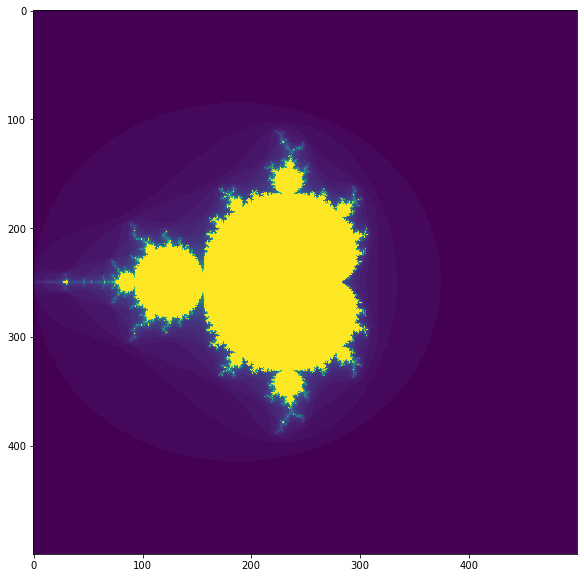

In [34]:
plt.figure(figsize=(10,10))
plt.imshow(make_fractal(size, iterations));

In [35]:
%%timeit
make_fractal(size, iterations)

/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in square
  # This is added back by InteractiveShellApp.init_path()
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in square
  # This is added back by InteractiveShellApp.init_path()
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in absolute
  if sys.path[0] == '':
/usr/share/miniconda/envs/compclass/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


192 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
@numba.jit(nopython=True)
def make_fractal_nb(size, iterations):
    x = np.linspace(-2,2,size[0]).reshape(1,-1)
    y = np.linspace(-2,2,size[1]).reshape(-1,1)
    c = x + y*1j
    z = np.zeros_like(c)
    it_matrix = np.zeros(size, dtype=np.int64)
    for n in range(iterations):
        for i in range(size[0]):
            for j in range(size[1]):
                if np.abs(z[i,j]) < 2:
                    z[i,j] = z[i,j]**2 + c[i,j]
                    it_matrix[i, j] = n
    return it_matrix

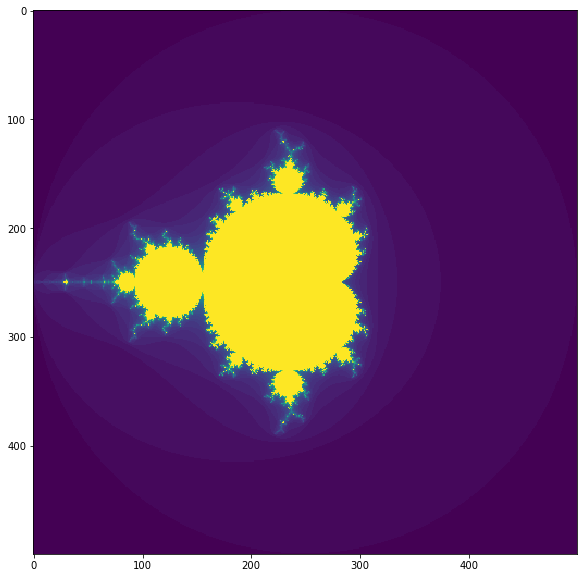

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(make_fractal_nb(size, iterations));

In [38]:
%%timeit
make_fractal_nb(size, iterations)

132 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### MCMC

This is our sampler for MCMC:

In [39]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

In [40]:
%%time
np.random.seed(123)
data = np.random.randn(20)

posterior = sampler(data, samples=1500, mu_init=1.)

CPU times: user 4.94 s, sys: 3.97 ms, total: 4.95 s
Wall time: 4.94 s


Now let's replace the scipy calls, and rerun:

In [41]:
def norm_pdf(loc, scale, x):
    y = (x - loc) / scale
    return np.exp(-y**2/2)/np.sqrt(2*np.pi) / scale

Make sure it's really the same:

In [42]:
assert norm_pdf(.4, .7, .2) == norm(.4, .7).pdf(.2)

In [43]:
assert norm(.3, 1).pdf(data).prod() == np.prod(norm_pdf(.3,1,data))

We'll also remove the list appending.

In [44]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    
    posterior = np.empty(samples+1)
    posterior[0] = mu_current
    
    for i in range(samples):
        # suggest new position
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = np.prod(norm_pdf(mu_current, 1, data))
        likelihood_proposal = np.prod(norm_pdf(mu_proposal, 1, data))
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm_pdf(mu_prior_mu, mu_prior_sd, mu_current)
        prior_proposal = norm_pdf(mu_prior_mu, mu_prior_sd, mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior[i+1] = mu_current
        
    return posterior

In [45]:
%%time
np.random.seed(123)
data = np.random.randn(20)

posterior = sampler(data, samples=1500, mu_init=1.)

CPU times: user 59.3 ms, sys: 0 ns, total: 59.3 ms
Wall time: 59.1 ms


Okay, instanciating scipy distributions over and over again is very costly....

In [46]:
@numba.jit
def norm_pdf(loc, scale, x):
    y = (x - loc) / scale
    return np.exp(-y**2/2)/np.sqrt(2*np.pi) / scale

In [47]:
@numba.jit(nopython=True)
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    
    posterior = np.empty(samples+1)
    posterior[0] = mu_current
    
    for i in range(samples):
        # suggest new position
        mu_proposal = np.random.normal(mu_current, proposal_width)

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = np.prod(norm_pdf(mu_current, 1, data))
        likelihood_proposal = np.prod(norm_pdf(mu_proposal, 1, data))
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm_pdf(mu_prior_mu, mu_prior_sd, mu_current)
        prior_proposal = norm_pdf(mu_prior_mu, mu_prior_sd, mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior[i+1] = mu_current
        
    return posterior

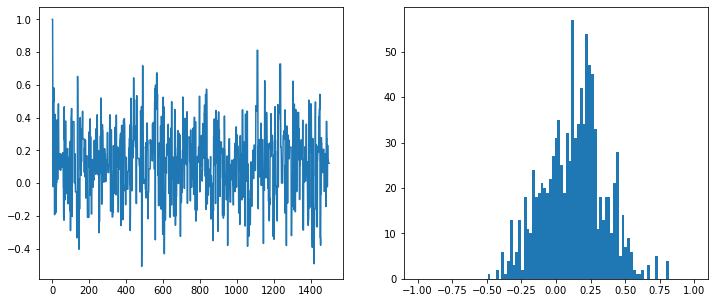

In [48]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
vals = sampler(data, samples=1500, mu_init=1.)
axs[0].plot(vals)
axs[1].hist(vals[500:], bins=np.linspace(-1,1,100))
plt.show()

In [49]:
%%time
np.random.seed(123)
data = np.random.randn(20)

posterior = sampler(data, samples=1500, mu_init=1.)

CPU times: user 1.87 ms, sys: 12 µs, total: 1.89 ms
Wall time: 1.88 ms
